In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy import signal
import scipy.io as io
%matplotlib inline

## Implementing ICA

The goal of this notebook is to implement ICA, projection pursuit and undercomplete ICA.

## source functions

In [2]:
class general_object(object):
    
    def __str__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    def __repr__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    
    def function(self, u):
        
        return None
    
    def first_derivative(self, u):
        
        return None
    
    def second_derivative(self, u):
        
        return None
    
    def gamma(self, u):
        
        return None
    
a = general_object()

print(a)

An object that implements the first derivative, second derivative and gamma functions of the XXXX function.


In [3]:
class sigmoid_object(object):
    
    def __str__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the sigmoid function."
    
    def __repr__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the sigmoid function."
    
    def function(self, u):
        
        return 1 / (1 + np.exp(-u))
    
    def first_derivative(self, u):
        
        return self.function(u) * (1 - self.function(u))
    
    def second_derivative(self, u):
        
        return self.first_derivative(u) * (1 - 2 * self.function(u))
    
    def gamma(self, u):
        
        return 1 - 2 * self.function(u)
    
class tanh_object(object):
    
    def __str__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    
    def __repr__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    
    def function(self, u):
        
        return (np.exp(u) - np.exp(-u)) / (np.exp(u) + np.exp(-u))
    
    def first_derivative(self, u):
        
        return 1 - self.function(u)**2
    
    def second_derivative(self, u):
        
        return -2 * self.first_derivative(u) * self.function(u)
    
    def gamma(self, u):
        
        return -2 * self.function(u)
    
class arctan_object(object):
    
    def __str__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    def __repr__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    
    def function(self, u):
        
        return np.arctan(u)
    
    def first_derivative(self, u):
        
        return 1 / (1 + u**2)
    
    def second_derivative(self, u):
        
        return -2 * u / (1 + u**2)
    
    def gamma(self, u):
        
        return -2 * u / (1 + u**2)**2
    
class generalised_sigmoid_object(object):
    
    def __init__(self, alpha):
        
        self.alpha = alpha #Slope parameter
    
    def __str__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    def __repr__(self):
        return "An object that implements the first derivative, second derivative and gamma functions of the XXXX function."
    
    def function(self, u):
        
        return 1 / (1 + np.exp(-self.alpha * u))
    
    def first_derivative(self, u):
        
        return self.alpha * self.function(u) * (1 - self.function(u))
    
    def second_derivative(self, u):
        
        return self.alpha * self.first_derivative(u) * (1 - 2 * self.function(u))
    
    def gamma(self, u):
        
        return self.alpha * (1 - 2 * self.function(u))



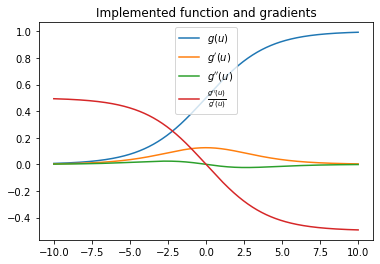

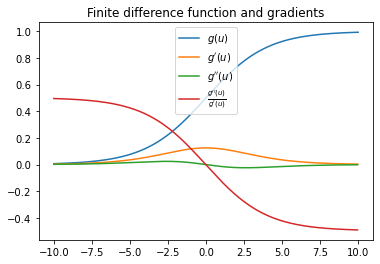

In [87]:
test_instance = generalised_sigmoid_object(0.5)#tanh_object()#generalised_sigmoid_object(5)#sigmoid_object()#arctan_object()#generalised_sigmoid_object(0.2)#
x = np.linspace(-10, 10, 1000)

plt.figure()
plt.title("Implemented function and gradients")
plt.plot(x, test_instance.function(x), label = r"$g(u)$")
plt.plot(x, test_instance.first_derivative(x), label = r"$g^{\prime}(u)$")
plt.plot(x, test_instance.second_derivative(x), label = r"$g^{\prime \prime}(u)$")
plt.plot(x, test_instance.gamma(x), label = r"$\frac{g^{\prime \prime}(u)}{g^{\prime}(u)}$")
plt.legend()
plt.show()

h = x[1] - x[0]
y = test_instance.function(x)
y_prime = np.diff(y, n = 1) / h
y_prime_prime = np.diff(y, n = 2) / h**2
plt.figure()
plt.title("Finite difference function and gradients")
plt.plot(x, y, label = r"$g(u)$")
plt.plot(x[:-1], y_prime, label = r"$g^{\prime}(u)$")
plt.plot(x[:-2], y_prime_prime, label = r"$g^{\prime \prime}(u)$")
plt.plot(x[:-2], y_prime_prime / y_prime[:-1], label = r"$\frac{g^{\prime \prime}(u)}{g^{\prime}(u)}$")
plt.legend()
plt.show()

In [90]:
class independent_component_analysis(object):
    
    def __init__(self, n_sources, source_name, source_params, preprocess_flag = True, vectorise = False):

        self.n_sources = n_sources
        self.source_name = source_name.lower()
        self.source_params = source_params #dictionary of parameters
        self.preprocess_flag = preprocess_flag
        self.vectorise = vectorise
        
        #Initialise the source PDFs
        self.initialise_sources()
        
    def initialise_preprocessing(self, X):
        
        #Extract Nsamples and Nfeatures
        Ns, Nf = X.shape
        
        if self.preprocess_flag:
            
            #Get the mean and standard deviation
            self.mean_ = np.mean(X, axis = 0, keepdims = True)
            self.std_ = np.std(X, axis = 0, keepdims = True)
            
            #Decompose X
            U, s, Vh = np.linalg.svd((X - self.mean_) / self.std_, full_matrices = False) 
            #rows of Vh are the eigenvectors of A^H A (i.e., Vh = U^T)
            #Columns of U are eigenvectors of A A^H
            self.Vh = Vh
            self.eigenvalues = s**2 / (Ns - 1)
            
            #Whiten the data
            L_inv_sqrt = np.diag(self.eigenvalues**(-1/2))
            
            self.latent_transform = np.dot(L_inv_sqrt, Vh)
            
        else:
            self.mean_ = np.zeros((1, Nf))
            self.std_ = np.ones((1, Nf))
            
            self.latent_transform = np.eye(Nf)
        
        return self
    
    def preprocess_data(self, X):
        
        X_standardised = (copy.deepcopy(X) - self.mean_) / self.std_
        X_whitened = np.dot(X_standardised, self.latent_transform.T)
        
        return X_whitened
    
    def initialise_sources(self):
        #Should return three methods: the function, its first derivative and its second derivative.
        
        if self.source_name == 'sigmoid':
            self.source_instance = sigmoid_object()
        
        elif self.source_name == 'tanh':
            self.source_instance = tanh_object()
        
        elif self.source_name == 'arctan':
            self.source_instance = arctan_object()
        
        elif self.source_name == 'generalised_sigmoid':
            self.source_instance = generalised_sigmoid_object(self.source_params['alpha'])
        
        else:
            print("Source name ({}) is unknown. Exiting the function.".format(self.source_name))
            raise SystemExit
        
        #self.first_derivative = self.source_instance.first_derivative
        #self.second_derivative = self.source_instance.second_derivative
        
        #Check to define the gamma factor
        #if not hasattr(self.source_instance, "gamma"):
        #    print("\nCreating the gamma object...")
        #    self.gamma = lambda u: self.second_derivative(u) / self.first_derivative(u)
        
        #else:
        #    self.gamma = self.source_instance.gamma
            
    def joint_entropy(self, X, Y, W):
        
        N, m = X.shape
        
        term1 = np.mean(np.sum(np.log(self.source_instance.first_derivative(Y) + 1e-12), axis = 1))
        
        if self.n_sources == m:
            detW = np.linalg.det(W)
            term2 = np.log(np.abs(detW) + 1e-12)
        
        else:
            C = np.dot(X.T, X)
            
            detW = np.linalg.det( np.dot(np.dot(W, C), W.T) )
            term2 = np.log(np.abs(detW) + 1e-12)
        
        return term1 + term2
    
    def matrix_derivative(self, X, Y, W):
        
        N, m = X.shape
        
        #Compute the first term
        term1 = np.zeros_like(W)

        #Transform Y
        gamma_Y = self.source_instance.gamma(Y)

        if self.vectorise:
            term1 = np.dot(gamma_Y.T, X)

        else:
            for n in range(N):
                term1 += np.dot(gamma_Y[[n], :].T , X[[n], :])

        #Normalise
        term1 *= 1/N
        
        #Compute the second term
        if self.n_sources == m:
            
            term2 = np.linalg.inv(W.T)
            
        elif self.n_sources < m:
            C = np.dot(X.T, X)
            
            inner = np.dot(np.dot(W, C), W.T)
            
            term2 = 1/N * np.dot(np.dot(C, W.T), np.linalg.inv(inner)).T
        
        return term1 + term2
        
    
    def fit(self, X, n_iters = 1, learning_rate = 0.1, tol = 1e-3):
        
        #Initialise pre-processing
        self.initialise_preprocessing(X)
        
        #Pre-process the data
        X_preprocess = self.preprocess_data(X)
        
        #Get number of sources
        N, m = X_preprocess.shape
        
        if self.n_sources is None:
            self.n_sources = m
            
        #Initialise weight matrix
        
        if self.n_sources == m:
            W = np.eye(m)
        else:
            W = 0.1 * np.random.randn(self.n_sources, m)
        
        #Determine initial entropy
        entropy = []
        gradient_norm = []
        
        error = np.inf
        cnt_iter = 0
        #Optimise the weight matrix
        while cnt_iter < n_iters and error >= tol:
            
            #Compute transform
            Y = np.dot(X_preprocess, W.T)
            
            #Compute and store entropy
            entropy.append(self.joint_entropy(X_preprocess, Y, W))
            
            #Determine matrix gradient
            W_grad = self.matrix_derivative(X_preprocess, Y, W)
            
            #self.vectorise = False
            #W_grad2 = self.matrix_derivative(X, Y, W)
            #print(np.linalg.norm(W_grad), np.linalg.norm(W_grad2))
            
            #Store the gradient norm
            gradient_norm.append(np.linalg.norm(W_grad))
            
            #Update weights
            W += learning_rate * W_grad
            
            #Normalise columns
            #W = W / np.sqrt(np.sum(W**2, axis = 1))
            
            if cnt_iter > 1:
                error = np.abs(entropy[cnt_iter] - entropy[cnt_iter - 1])
                
            cnt_iter += 1
        
        self.W = W
        self.entropy_ = np.array(entropy)
        self.grad_norm_ = np.array(gradient_norm)
        
        return self

## Test on toy Gaussian data

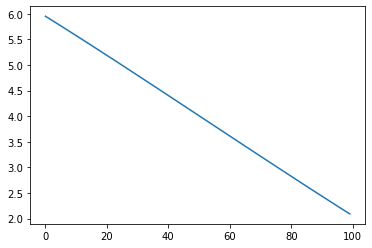

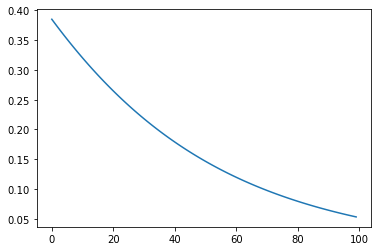

In [9]:
test_data = np.random.multivariate_normal(mean = np.zeros(2), cov = np.array([[10, 0.7], [0.7, 1]]), size = 10000)

ICA = independent_component_analysis(n_sources = 1,
                                     source_name = 'tanh', 
                                     source_params = None, 
                                     preprocess_flag = True)

ICA.fit(test_data, n_iters = 100, learning_rate = 0.01)

plt.figure()
plt.plot(ICA.entropy_)
plt.show()

plt.figure()
plt.plot(ICA.grad_norm_)
plt.show()

## Test data

In [78]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
time = np.linspace(0, 8, 10000)
"""
# Source matrix
S = np.array([np.sin(time * 1),
              signal.sawtooth(time * 1.9)]).T

# Mixing matrix
A = np.random.randn(2, 2)
"""

#S = np.array([np.sin(time * 1),
#              signal.sawtooth(time * 1.9),
#              np.random.random(len(time))]).T

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = np.random.random(len(time))#signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signal matrix
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
print(X.shape)

(10000, 3)


In [70]:
import scipy.io as io
X = io.loadmat("test_matrices.mat")["x"].T
X = np.hstack((X, np.random.randn(X.shape[0]).reshape(-1, 1)))
print(X.shape)

(10000, 3)


In [54]:
data_dir = "D:/PhD_Files/Datasets/Phenomenological/Dataset4/Exp1_Uh_R0199.mat"

data_mat = io.loadmat(data_dir)

x_signal = data_mat["x_total"][0, :]

def hankel_mat(signal, Lw, Lsft):
    
    start = 0
    end = Lw
    
    H = []
    
    while end < len(signal):
        H.append(signal[start:end])
        
        start += Lsft
        end += Lsft
    
    return np.array(H)

X = hankel_mat(x_signal, 32, 1)
print(X.shape)
    

(24968, 32)


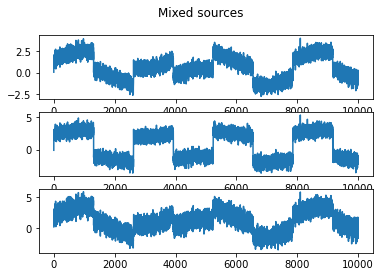

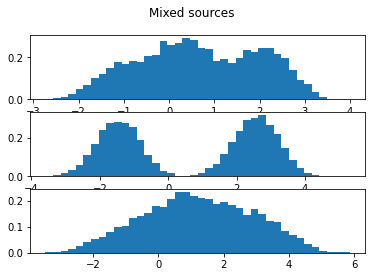

In [79]:
fig, ax = plt.subplots(X.shape[1], 1)
ax = ax.flatten()
fig.suptitle("Mixed sources")
for i in range(X.shape[1]):
    ax[i].plot(X[:, i])
plt.show()

fig, ax = plt.subplots(X.shape[1], 1)
ax = ax.flatten()
fig.suptitle("Mixed sources")
for i in range(X.shape[1]):
    ax[i].hist(X[:, i], density = True, bins = 40)
plt.show()

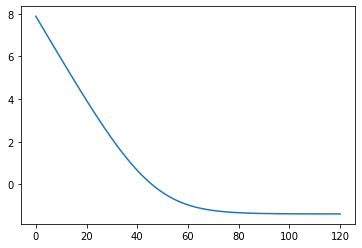

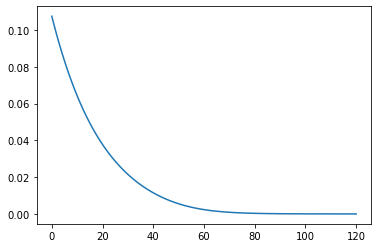

[[ 0.06836041 -0.09273981  0.22784828]
 [ 1.94244272  2.86932396  2.96002182]
 [ 1.68572107  2.60158276  2.45321301]
 ...
 [-1.10307029 -2.03269747 -1.05850878]
 [-0.86312243 -1.63060303 -0.45071178]
 [-1.2940975  -2.1176212  -1.59059998]]


In [95]:
ICA = independent_component_analysis(n_sources = 2,
                                     source_name = 'generalised_sigmoid', 
                                     source_params = {"alpha": 1}, 
                                     preprocess_flag = True, 
                                     vectorise = True)

ICA.fit(X, n_iters = 2000, learning_rate = 0.1, tol = 1e-4)

plt.figure()
plt.plot(ICA.entropy_)
plt.show()

plt.figure()
plt.plot(ICA.grad_norm_)
plt.show()

print(X)

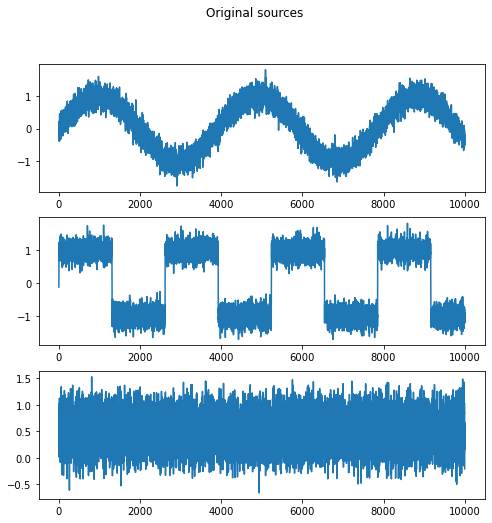

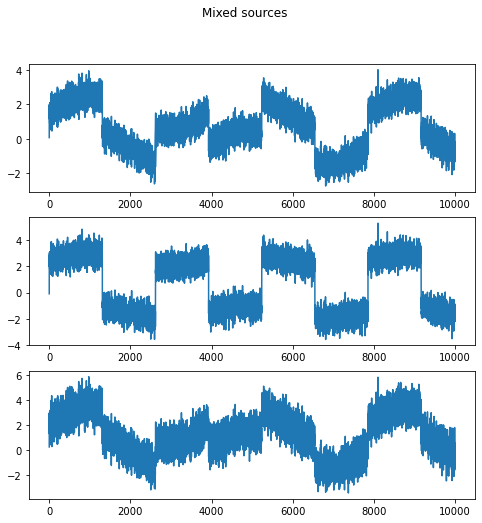

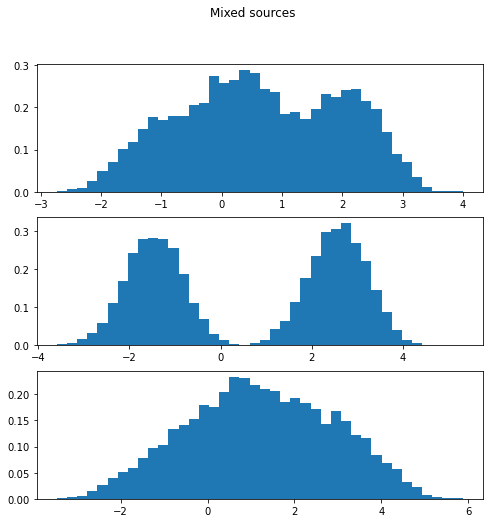

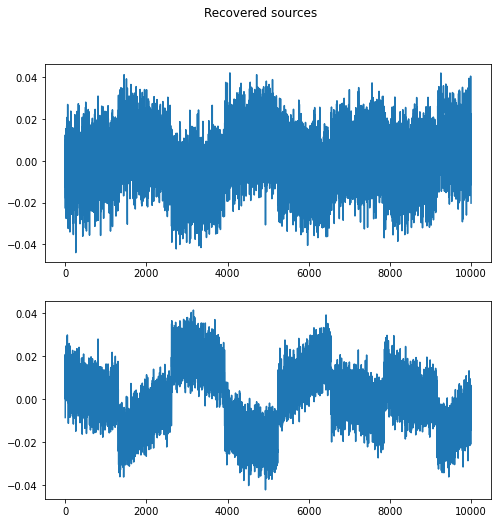

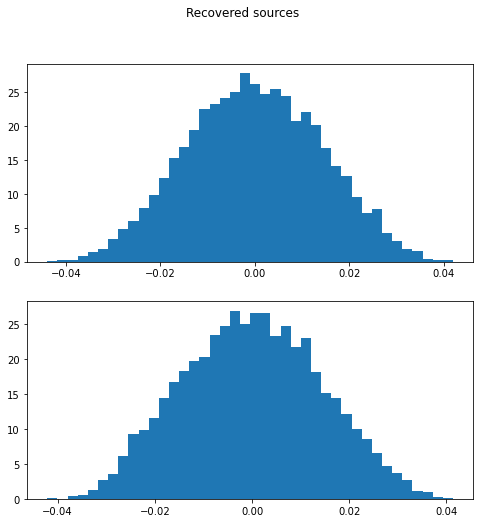

[[-0.0001112  -0.01038122 -0.00960723]
 [ 0.00661071  0.00845541 -0.00921622]]


In [96]:
S_recover = np.dot(ICA.preprocess_data(X), ICA.W.T)

fig, ax = plt.subplots(X.shape[1], 1, figsize = (8, 8))
fig.suptitle("Original sources")
ax = ax.flatten()
for i in range(S.shape[1]):
    ax[i].plot(S[:, i])
plt.show()

fig, ax = plt.subplots(X.shape[1], 1, figsize = (8, 8))
fig.suptitle("Mixed sources")
ax = ax.flatten()
for i in range(X.shape[1]):
    ax[i].plot(X[:, i])
plt.show()

fig, ax = plt.subplots(X.shape[1], 1, figsize = (8, 8))
fig.suptitle("Mixed sources")
ax = ax.flatten()
for i in range(X.shape[1]):
    ax[i].hist(X[:, i], density = True, bins = 40)
plt.show()

print("\n\n\n")
fig, ax = plt.subplots(S_recover.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources")
for i in range(S_recover.shape[1]):
    ax[i].plot(S_recover[:, i])
plt.show()

fig, ax = plt.subplots(S_recover.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources")
for i in range(S_recover.shape[1]):
    ax[i].hist(S_recover[:, i], density = True, bins = 40)
plt.show()

W = ICA.W

print(W)

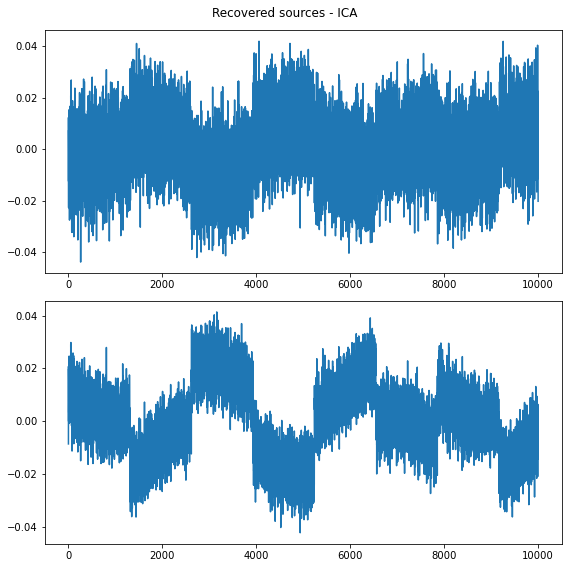

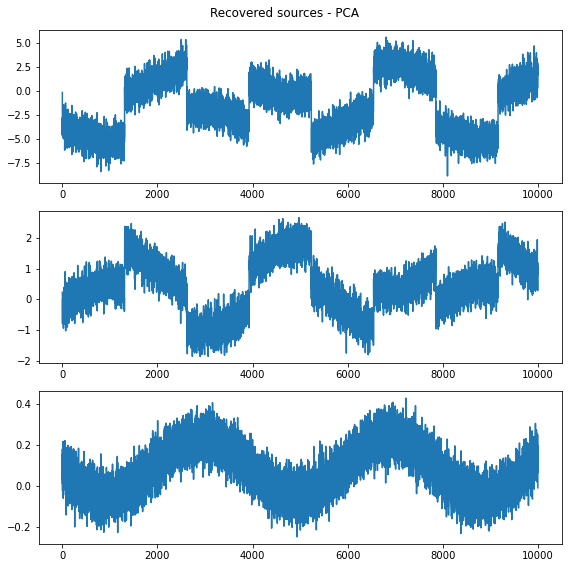

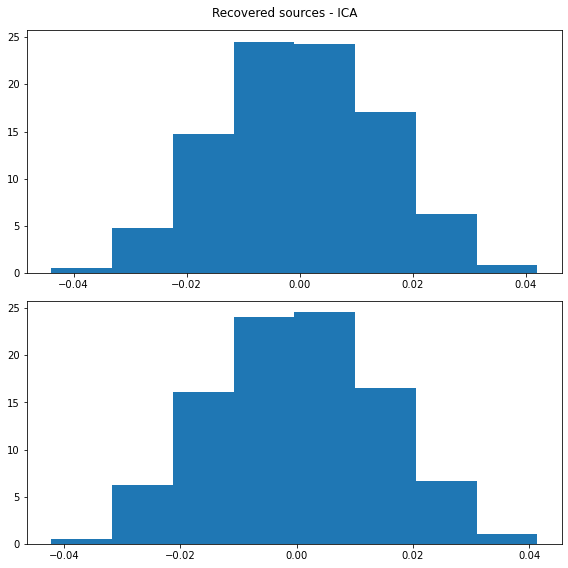

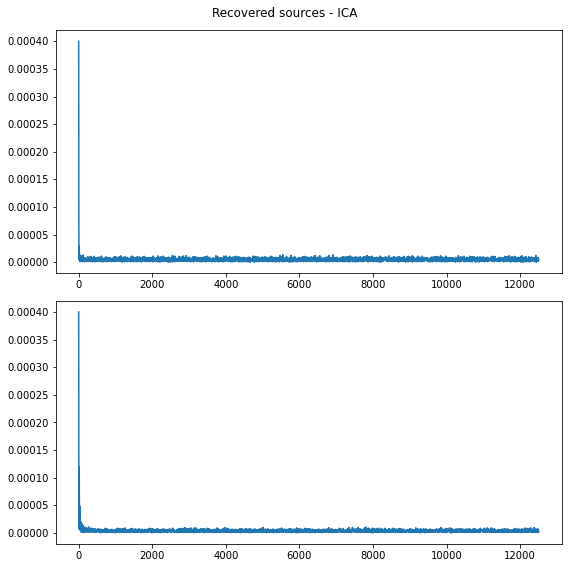

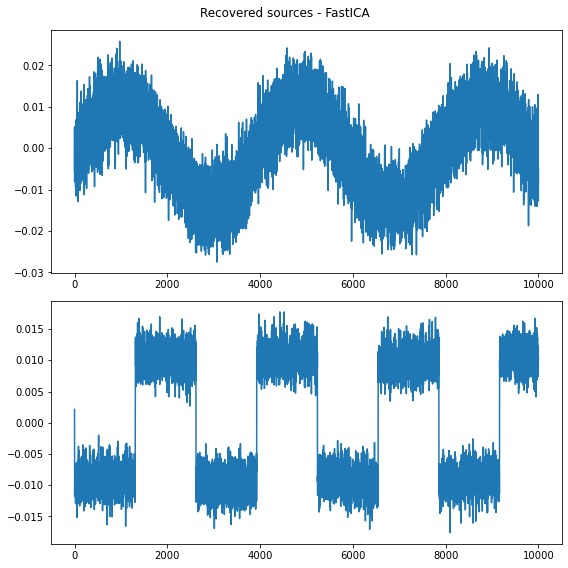

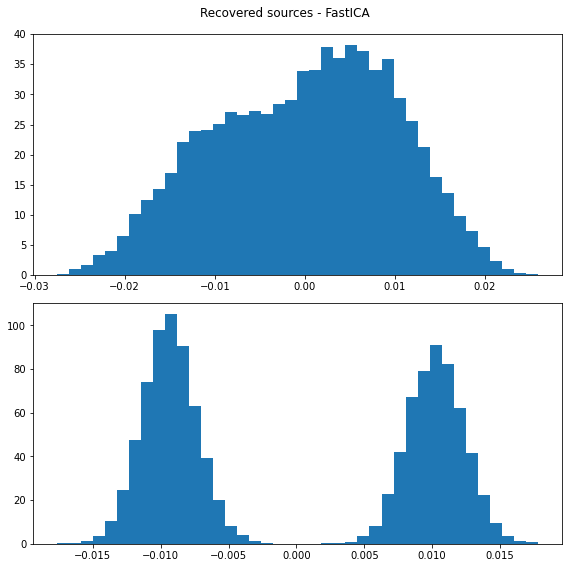

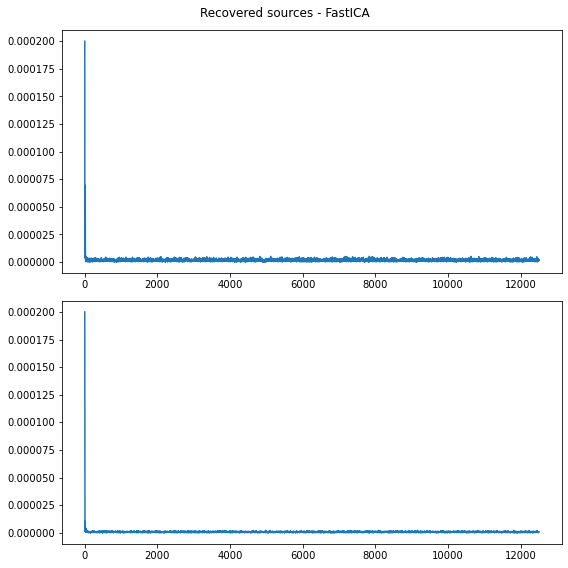

In [97]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components = 2)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

U, s, V = np.linalg.svd(X)

S_pca = np.dot(X, V.T)

fig, ax = plt.subplots(S_recover.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources - ICA")
for i in range(S_recover.shape[1]):
    ax[i].plot(S_recover[:, i])
    #ax[i].set_xlim(0, 1000)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(S_pca.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources - PCA")
for i in range(S_pca.shape[1]):
    ax[i].plot(S_pca[:, i])
    #ax[i].set_xlim(0, 1000)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(S_recover.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources - ICA")
for i in range(S_recover.shape[1]):
    ax[i].hist(S_recover[:, i], density = True, bins = 8)
fig.tight_layout()
plt.show()


fig, ax = plt.subplots(S_recover.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources - ICA")
for i in range(S_recover.shape[1]):
    n = X.shape[0]
    freq = np.fft.fftfreq(n, 1/25e3)[:n//2]
    val = 2/n * np.abs(np.fft.fft(S_recover[:, i]**2))[:n//2]
    ax[i].plot(freq, val)
    #ax[i].set_xlim(0, 1000)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(S_.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources - FastICA")
for i in range(S_.shape[1]):
    ax[i].plot(S_[:, i])
    #ax[i].set_xlim(0, 1000)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(S_.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources - FastICA")
for i in range(S_.shape[1]):
    ax[i].hist(S_[:, i], density = True, bins = 40)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(S_.shape[1], 1, figsize = (8, 8))
ax = ax.flatten()
fig.suptitle("Recovered sources - FastICA")
for i in range(S_.shape[1]):
    n = X.shape[0]
    freq = np.fft.fftfreq(n, 1/25e3)[:n//2]
    val = 2/n * np.abs(np.fft.fft(S_[:, i]**2))[:n//2]
    ax[i].plot(freq, val)
    #ax[i].set_xlim(0, 1000)

fig.tight_layout()
plt.show()

In [84]:
S_pca.shape

(10000, 3)

<IPython.core.display.Javascript object>


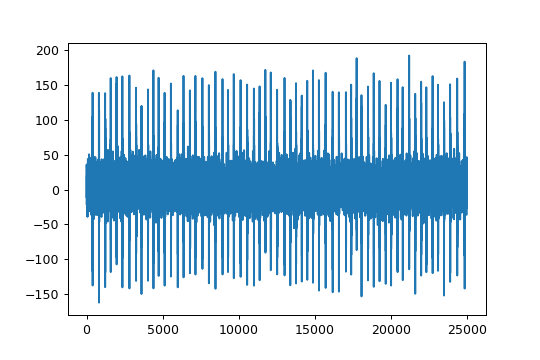

<IPython.core.display.Javascript object>


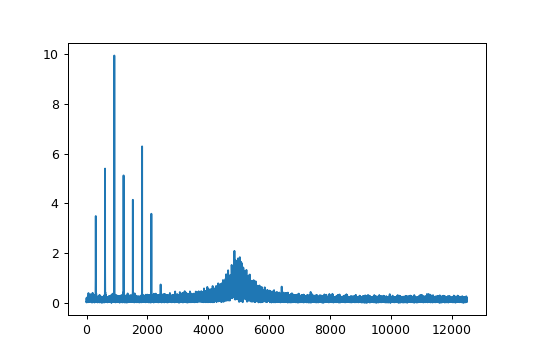

<IPython.core.display.Javascript object>


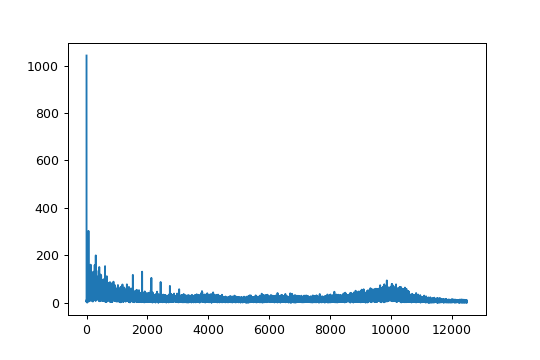

In [60]:
%matplotlib notebook

plt.figure()
plt.plot(x_signal)
plt.show()

n = len(x_signal)
freq = np.fft.fftfreq(n, 1/25e3)[:n//2]
val = 2/n * np.abs(np.fft.fft(x_signal))[:n//2]
val2 = 2/n * np.abs(np.fft.fft(x_signal**2))[:n//2]

plt.figure()
plt.plot(freq, val)
plt.show()

plt.figure()
plt.plot(freq, val2)
plt.show()